In [1]:
using LaTeXStrings
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
# using Optim
using Distributions
import Random

using Revise
using DeconvolveDistribution
using DeconvolveDistribution: coefs, ExpoSpline
;

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/imolk/Library/Julia/alternative_depots/deconvolve/packages/PyPlot/4wzW1/src/init.jl:192
┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1273
┌ Warning: Package Distributions does not have Test in its dependencies:
│ - If you have Distributions checked out for development and have
│   added Test as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Distributions
└ Loading Test into Distributions from project dependency, future warnings for Distributions are suppressed.
┌ Info: Precompiling DeconvolveDistribution [ce248477-2e98-51a1-a641-d405f74c103f]
└ @ Base loading.jl:1273


In [2]:
# simulate some data
n = 400
F_X = MixtureModel([Normal(-1, 1), Normal(2, 0.8)], [0.6, 0.4])
σ_distr = Gamma(1.0, 4.0)
Random.seed!(1)
X = rand(F_X, n)
σ = rand(σ_distr, n)
U_distr = Normal.(0.0, σ)
U = rand.(U_distr)
W = X .+ U
;

# Fourier

In [3]:
# estimate F_X from simulated data
n_xx = 500
F_xx = collect(range(-8.0, stop=8.0, length=n_xx))
num_t = 50
h = 0.2
;

In [4]:
decon_settings = DeconvolveDistribution.FourierDeconv(h, F_xx, num_t)
decon_distr = DeconvolveDistribution.decon(decon_settings, W, U_distr)
;

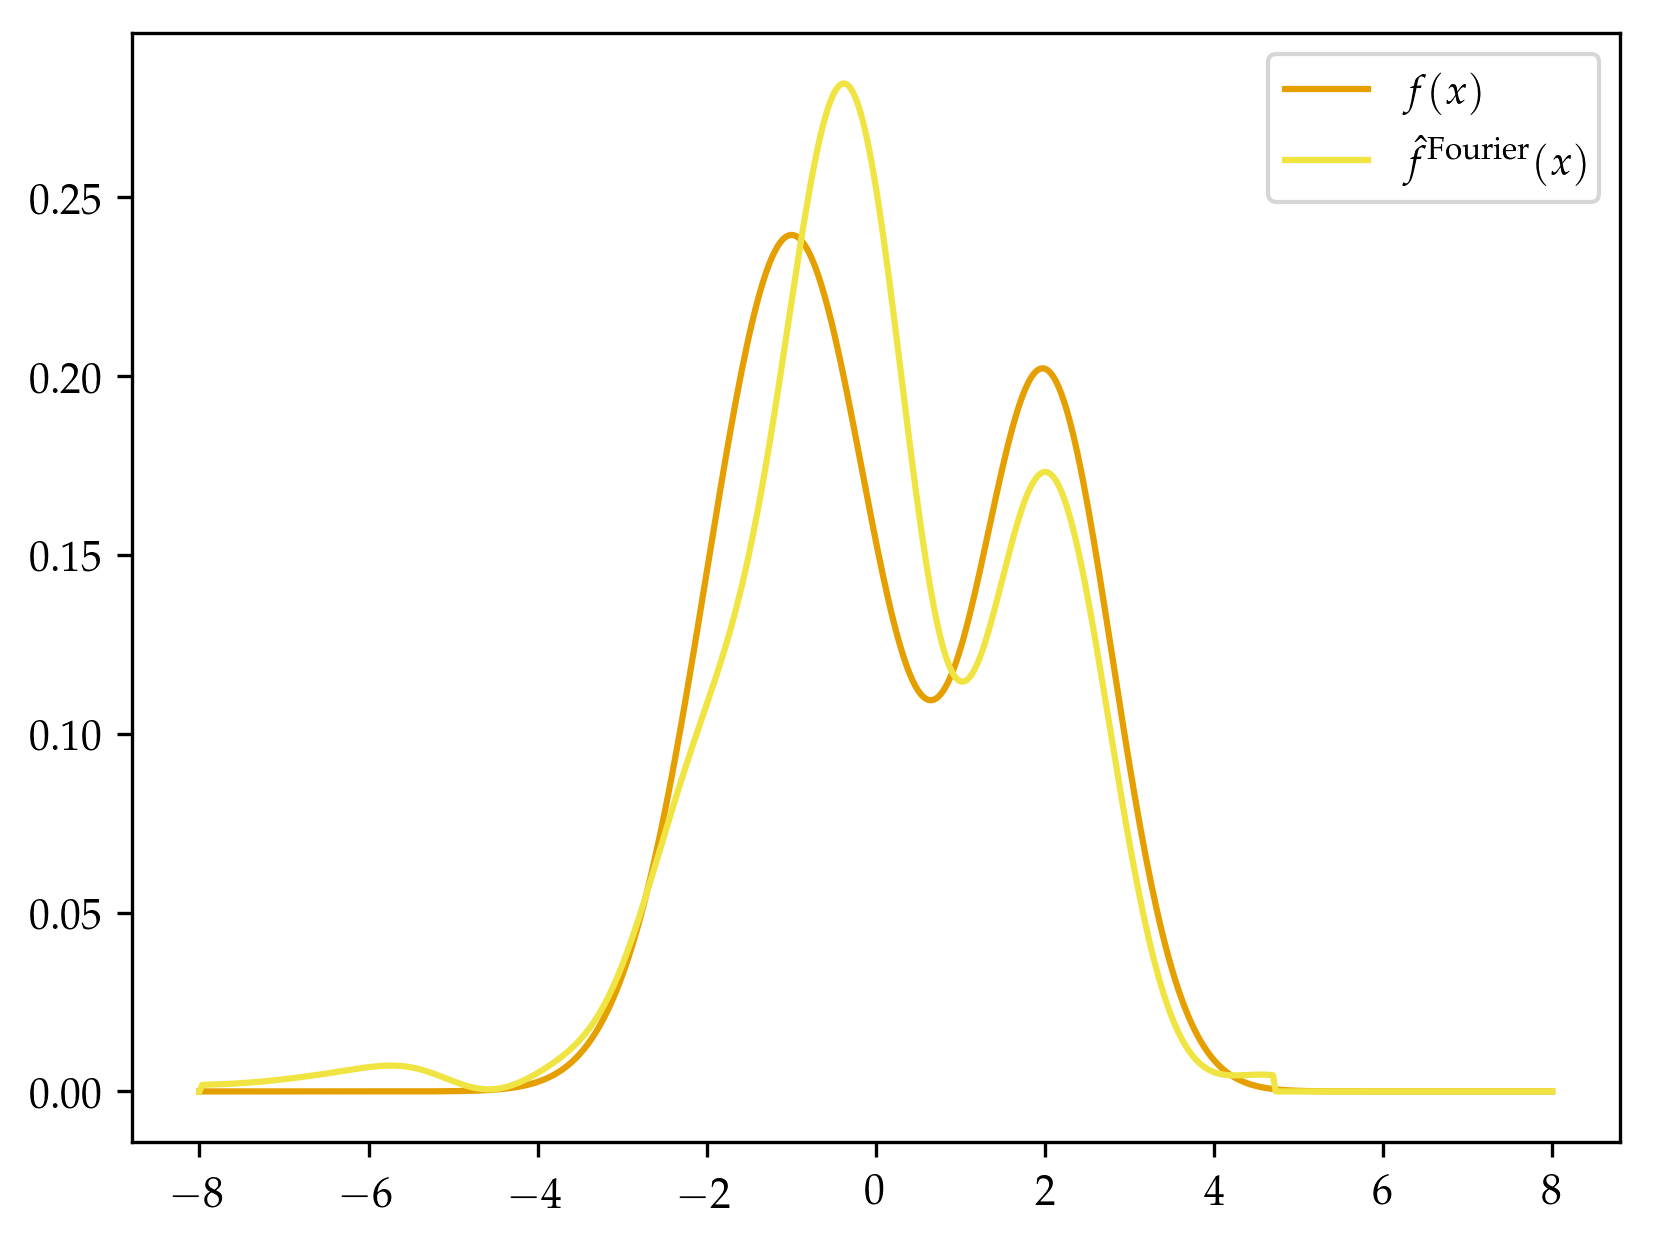

PyObject <matplotlib.legend.Legend object at 0x169c68358>

In [5]:
plt.plot(F_xx, pdf.(F_X, F_xx), color=cbbPalette[1], label=L"f(x)")

fhat_decon_distr = pdf.(decon_distr, F_xx)
plt.plot(F_xx, fhat_decon_distr, color=cbbPalette[4], label=L"\hat{f}^{\mathrm{Fourier}}(x)")

# plt.plt[:hist](rand(decon_distr, 10_000), bins=100, normed=true, alpha=0.2)

plt.legend(loc="top left")

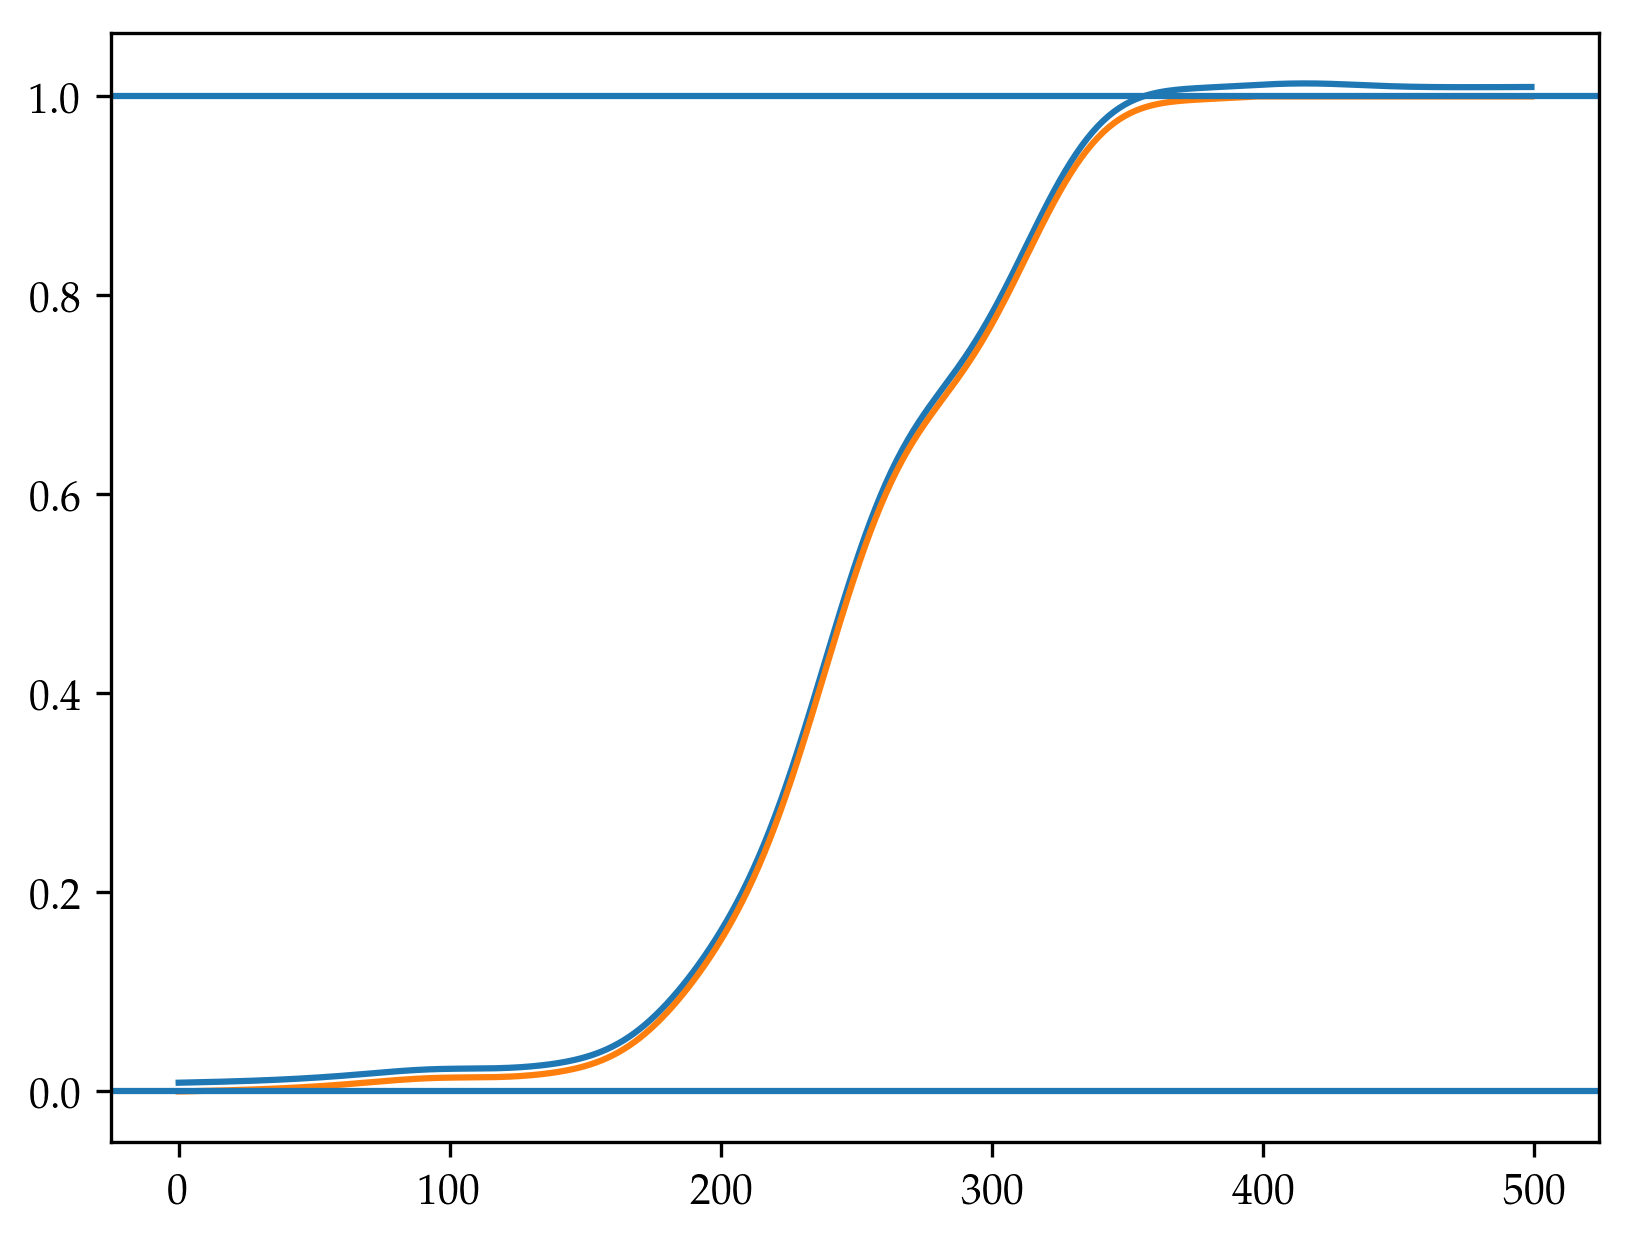

PyObject <matplotlib.lines.Line2D object at 0x16d0f1c50>

In [6]:
function push_negative_prob!(prob_vec, p::Real)
    i = 0
    while p < 0
        i += 1
        if i == length(prob_vec)
            p = 0.0
            break
        end
        p += prob_vec[i] # pick this bit of probability up
        prob_vec[i] = 0.0 # new probability is zero
    end
    prob_vec[i] = p
end
function fix_CDF!(Fhat_xx)
    discretised_pdf = diff(Fhat_xx)
    while minimum(discretised_pdf) < 0.0
        imin = argmin(discretised_pdf)
        pmin = discretised_pdf[imin]
        discretised_pdf[imin] = 0.0
        discretised_left = @view(discretised_pdf[imin-1:-1:1])
        push_negative_prob!(discretised_left, pmin / 2)
        discretised_right = @view(discretised_pdf[imin+1:end])
        push_negative_prob!(discretised_right, pmin / 2)
    end
    corrected_cdf = cumsum(discretised_pdf)
    corrected_cdf .-= minimum(corrected_cdf)
    corrected_cdf ./= maximum(corrected_cdf)
    @assert maximum(corrected_cdf) ≈ 1.0
    Fhat_xx[1] = 0.0
    Fhat_xx[2:end] .= corrected_cdf
    return Fhat_xx
end

let
    dm = decon_settings
    ϵdistr = U_distr
    Fhat_xx = DeconvolveDistribution.Fhat(dm.Xgrid, W, dm.num_t, dm.bandwidth, ϵdistr)
    plt.plot(Fhat_xx)
    fix_CDF!(Fhat_xx)
    plt.plot(Fhat_xx)
    plt.axhline(0.0)
    plt.axhline(1.0)
end

# Efron

In [7]:
function plot_pdf(d::DeconvolveDistribution.ExpoSpline; kwargs...)
    p = pdf(d)
    θ = d.domain
    Δ = median(diff(θ))
    plt.bar(θ, p./Δ, Δ; kwargs...)
end

plot_pdf (generic function with 1 method)

In [8]:
Random.seed!(3)
θvec = collect(range(-5,stop=5,length=61))
d = ExpoSpline(θvec, randn(8))
;

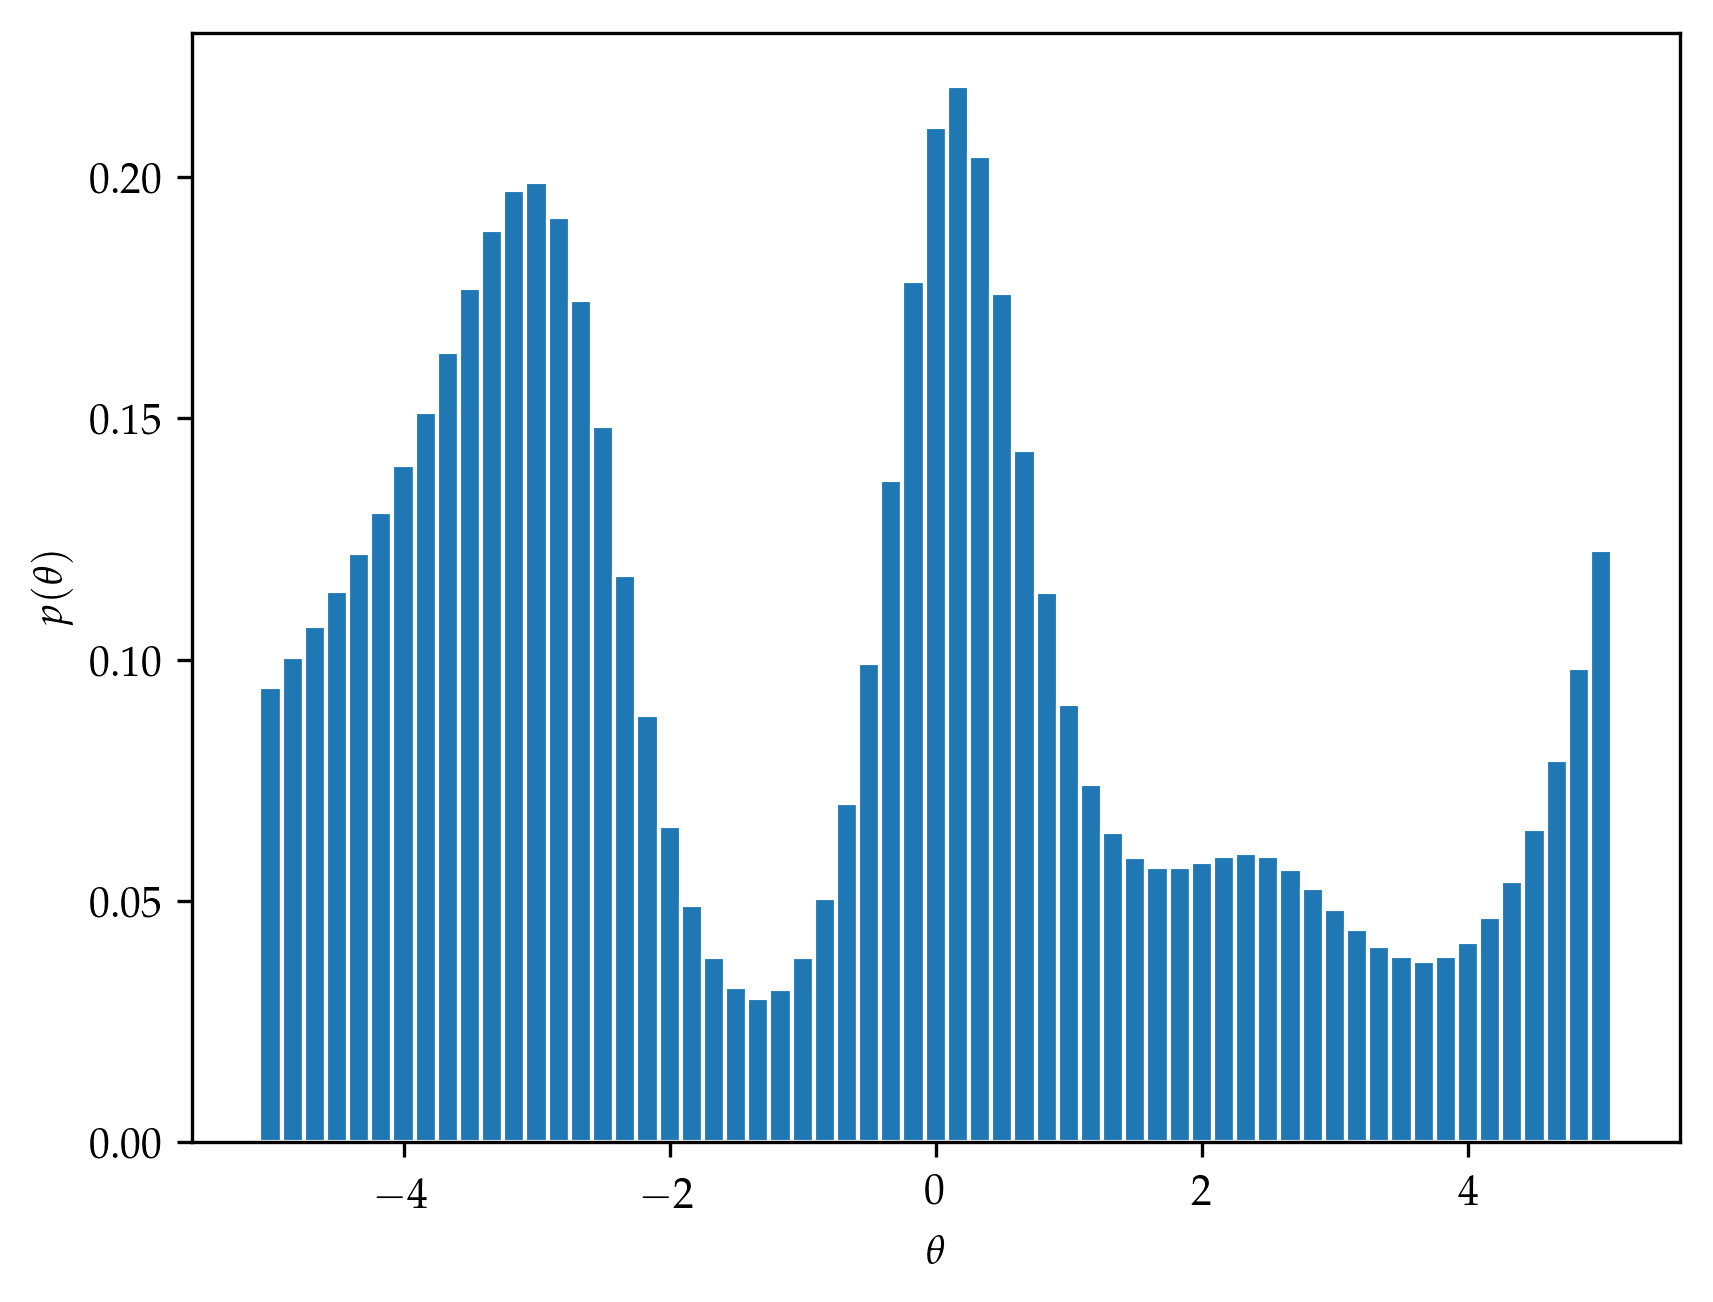

In [9]:
plot_pdf(d, edgecolor="white")
plt.xlabel(L"\theta")
plt.ylabel(L"p(\theta)")
;

In [10]:
dm = DeconvolveDistribution.EfronDeconv(7, θvec, 2.0)
d_optim = DeconvolveDistribution.decon(dm, W, U_distr)
;

In [11]:
@time d_optim = DeconvolveDistribution.decon(dm, W, U_distr);

  0.085867 seconds (13.49 k allocations: 99.904 MiB, 22.94% gc time)


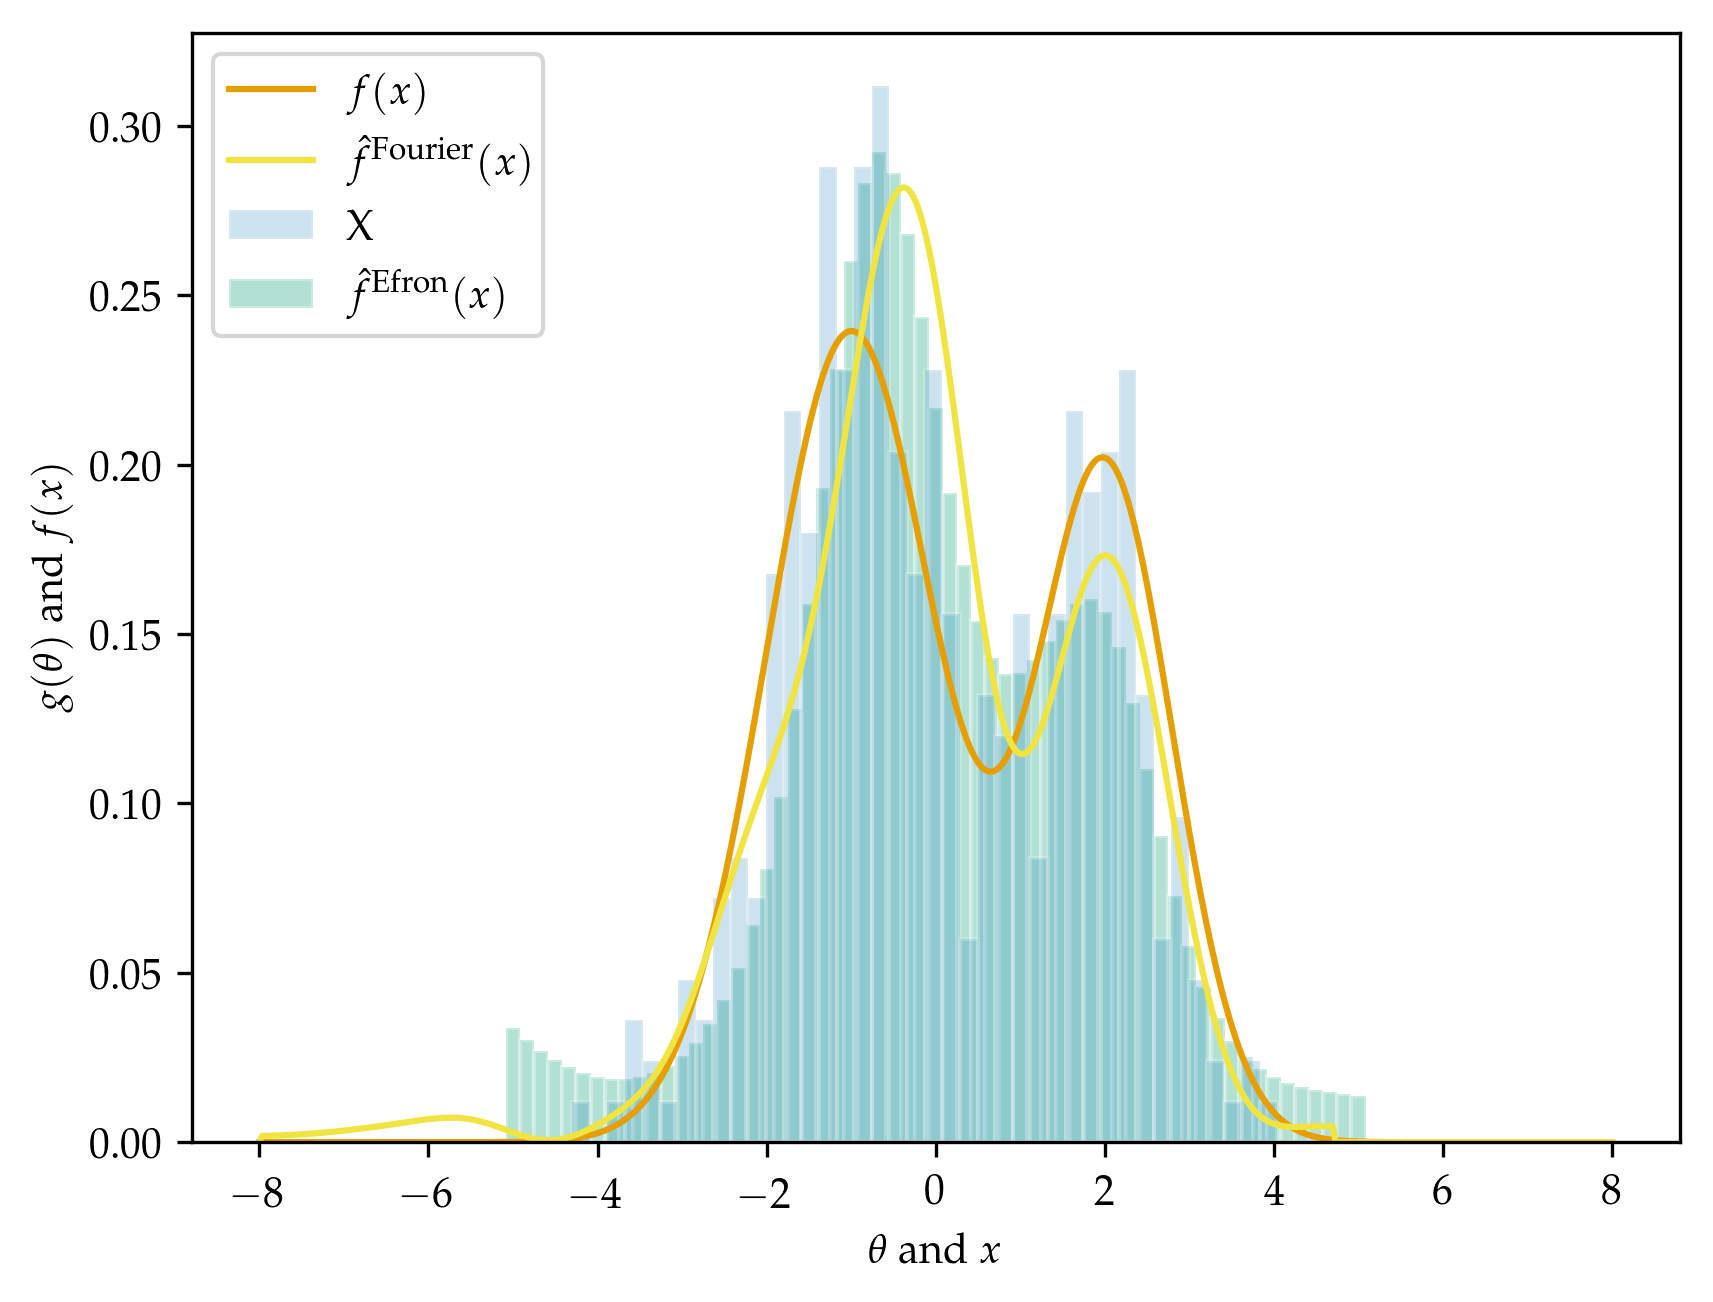

In [12]:
plt.plot(F_xx, pdf.(F_X, F_xx), color=cbbPalette[1], label=L"f(x)")
plot_pdf(d_optim; facecolor=cbbPalette[3], alpha=0.3, 
        edgecolor="white", label=L"\hat{f}^{\mathrm{Efron}}(x)")
plt.plot(F_xx, fhat_decon_distr, color=cbbPalette[4], label=L"\hat{f}^{\mathrm{Fourier}}(x)")
plt.hist(X; color=cbbPalette[5], alpha=0.2, edgecolor="white", bins=40, normed=true, label="X")
plt.ylabel(L"$g(\theta)$ and $f(x)$")
plt.xlabel(L"$\theta$ and $x$")
plt.legend(loc="upper left")
;